In [56]:
## Create combined DE csv from both datasets
import pandas as pd

# Adjusted file paths
path_df1 = "~/Desktop/Capstone/Notebook recent/GSE180286_DE_oncogenes.csv"
path_df2 = "~/Desktop/Capstone/Notebook recent/GSE161529_DE_oncogenes.csv"

# Load the datasets and tag with dataset source
df1 = pd.read_csv(path_df1)
df1["Dataset"] = "GSE180286"

df2 = pd.read_csv(path_df2)
df2["Dataset"] = "GSE161529"

# Standardize gene column if needed
df1["gene"] = df1["gene"].str.upper()
df2["gene"] = df2["gene"].str.upper()

# Combine both
combined_df = pd.concat([df1, df2], ignore_index=True)

# Save combined file
combined_df.to_csv("~/Desktop/Capstone/Notebook recent/combined_de_genes.csv", index=False)

print("✅ combined_de_genes.csv created successfully.")

✅ combined_de_genes.csv created successfully.


In [57]:
import pandas as pd

# 🔹 Step 1: Load the annotated differential expression results
df = pd.read_csv("~/Desktop/Capstone/Notebook recent/combined_de_genes.csv")
# 🔹 Step 5: Sort by dataset and log2 fold-change
#df = df.sort_values(by=["Dataset", "log2FC"], ascending=[True, False])
df.head(3)


,gene,p_value,log2_fc,mean_diff,Dataset
0,CDK4,0.0,2.428112,0.105542,GSE180286
1,CDKN1A,0.0,3.365022,0.134859,GSE180286
2,ERBB2,0.0,4.833174,0.267847,GSE180286


In [3]:
## Step 1: Load DGIdb interaction data and extract druggable genes

import pandas as pd
import os

# Load DGIdb interactions.tsv (adjust path as needed)
dgidb_path = os.path.expanduser("~/Desktop/Cancer_project/ghost-cell-busters/interactions.tsv")
dgidb_df = pd.read_csv(dgidb_path, sep="\t")

# Filter druggable genes: approved or anti-neoplastic
dgidb_filtered = dgidb_df[
    (dgidb_df["approved"] == True) | (dgidb_df["anti_neoplastic"] == True)
]

# Unique druggable gene symbols (uppercased for consistency)
druggable_genes = dgidb_filtered["gene_name"].dropna().str.upper().unique()
print(f"Number of druggable genes from DGIdb: {len(druggable_genes)}")


Number of druggable genes from DGIdb: 3579


In [4]:
## Step 2: Query Open Targets API for breast cancer target association scores
import requests

url = "https://api.platform.opentargets.org/api/v4/graphql"
query = """
query BreastCancerTargets($efoId: String!, $size: Int!) {
  disease(efoId: $efoId) {
    associatedTargets(page: { index: 0, size: $size }) {
      rows {
        target {
          approvedSymbol
        }
        score
      }
    }
  }
}
"""
variables = {
    "efoId": "EFO_0000305",  # Breast cancer EFO ID
    "size": 500
}

response = requests.post(url, json={"query": query, "variables": variables})
data = response.json()

if "errors" in data:
    raise Exception(f"Open Targets API error: {data['errors']}")

rows = data["data"]["disease"]["associatedTargets"]["rows"]

open_targets_df = pd.DataFrame([
    {
        "Gene": row["target"]["approvedSymbol"].upper(),
        "OpenTargets_Score": row["score"]
    }
    for row in rows if row.get("score") is not None
])

# Filter strong breast cancer associations
open_targets_df = open_targets_df[open_targets_df["OpenTargets_Score"] >= 0.5]

print(f"Number of genes strongly associated with breast cancer (Open Targets): {open_targets_df.shape[0]}")


Number of genes strongly associated with breast cancer (Open Targets): 316


In [5]:
## Step 3: Merge DE genes with DGIdb and Open Targets info
# Ensure gene symbols uppercase in DE dataframe for consistency
df["Gene"] = df["gene"].str.upper()

# Add DGIdb Status
df["DGIdb Status"] = df["Gene"].apply(lambda x: "Targeted" if x in druggable_genes else "Not Targeted")

# Merge with Open Targets scores (left join to keep all DE genes)
df = df.merge(open_targets_df, how="left", left_on="Gene", right_on="Gene")

# Add breast cancer support flags
df["BreastCancer_Supported"] = df["OpenTargets_Score"].notna()
df["Strong_BreastCancer_Support"] = df["OpenTargets_Score"].fillna(0) >= 0.5



In [6]:
## Step 4: Add FDA approval info from DGIdb data 
# To get FDA approval status, use the dgidb_filtered dataframe:
# Extract gene-wise FDA approval flag

# Prepare dictionary mapping gene -> FDA approved (True/False)
fda_dict = dgidb_filtered.groupby("gene_name")["approved"].max().to_dict()

# Map it onto df
df["FDA_Approved_Drug"] = df["Gene"].map(fda_dict).fillna(False)
df["FDA_Approved_Drug"] = df["FDA_Approved_Drug"].map({True: "Yes", False: "No"})


In [7]:
## Step 5: Assign therapeutic categories specific to breast cancer

def assign_targeting_category(row):
    if row["Strong_BreastCancer_Support"]:
        if row["DGIdb Status"] == "Targeted":
            if row["FDA_Approved_Drug"] == "Yes":
                return "FDA-approved Breast Cancer Therapy"
            else:
                return "Emerging Breast Cancer Target"
        else:
            return "Lacks Breast Cancer Evidence"
    else:
        return "Lacks Breast Cancer Evidence"

df["Targeting Category"] = df.apply(assign_targeting_category, axis=1)


In [8]:
##Step 6: Save the annotated dataframe

output_path = os.path.expanduser("~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_30July.csv")
df.to_csv(output_path, index=False)
print(f"✅ Saved annotated therapeutic stratification to {output_path}")


✅ Saved annotated therapeutic stratification to /Users/adi/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_30July.csv


In [9]:
##Load and review the saved CSV contents, including summary statistics for therapeutic categories:
import pandas as pd

# Load the annotated therapeutic stratification CSV
csv_path = "~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_30July.csv"
df = pd.read_csv(csv_path)

# Show the first few rows
print("### Preview of data ###")
print(df.head())

# Summary of therapeutic categories
print("\n### Therapeutic Category counts ###")
print(df['Targeting Category'].value_counts())

# Summary statistics for log2FC by category
print("\n### Summary statistics of log2FC by Targeting Category ###")
print(df.groupby('Targeting Category')['log2_fc'].describe())

# Optional: List unique genes per category
for cat in df['Targeting Category'].unique():
    genes = df.loc[df['Targeting Category'] == cat, 'gene'].unique()
    print(f"\nCategory: {cat} — {len(genes)} unique genes")
    print(genes[:10])  # print first 10 genes



### Preview of data ###
     gene  p_value   log2_fc  mean_diff    Dataset    Gene DGIdb Status  \
0    CDK4      0.0  2.428112   0.105542  GSE180286    CDK4     Targeted   
1  CDKN1A      0.0  3.365022   0.134859  GSE180286  CDKN1A     Targeted   
2   ERBB2      0.0  4.833174   0.267847  GSE180286   ERBB2     Targeted   
3   CCND1      0.0  4.525871   0.483840  GSE180286   CCND1     Targeted   
4  CDKN2A      0.0  3.926487   0.074630  GSE180286  CDKN2A     Targeted   

   OpenTargets_Score  BreastCancer_Supported  Strong_BreastCancer_Support  \
0           0.693263                    True                         True   
1                NaN                   False                        False   
2           0.820020                    True                         True   
3           0.568711                    True                         True   
4           0.592468                    True                         True   

  FDA_Approved_Drug                  Targeting Category  
0   

In [11]:
# Assuming your dataframe is named df

# Drop duplicates based on 'gene' column, keeping the first occurrence
df_unique = df.drop_duplicates(subset='gene', keep='first').reset_index(drop=True)

# Check counts to confirm
print("Counts after deduplication by gene:")
print(df_unique['Targeting Category'].value_counts())
print(f"Total unique genes: {df_unique['gene'].nunique()}")

# Now df_unique is ready for downstream analysis
for category, group in df_unique.groupby('Targeting Category'):
    genes = group['gene'].tolist()
    print(f"\nCategory: {category} — {len(genes)} unique genes")
    print(genes)



Counts after deduplication by gene:
Targeting Category
FDA-approved Breast Cancer Therapy    31
Lacks Breast Cancer Evidence           8
Emerging Breast Cancer Target          1
Name: count, dtype: int64
Total unique genes: 40

Category: Emerging Breast Cancer Target — 1 unique genes
['CASP8']

Category: FDA-approved Breast Cancer Therapy — 31 unique genes
['CDK4', 'ERBB2', 'CCND1', 'CDKN2A', 'FOXO3', 'KRAS', 'FGFR1', 'MDM2', 'NF1', 'AKT1', 'BRCA1', 'HRAS', 'TP53', 'CDK6', 'PTEN', 'MYC', 'BRCA2', 'PIK3CA', 'RB1', 'BCL2', 'MET', 'EGFR', 'NTRK2', 'TSC2', 'STK11', 'FGFR2', 'ATR', 'NOTCH1', 'SMAD4', 'CHEK2', 'ATM']

Category: Lacks Breast Cancer Evidence — 8 unique genes
['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']


In [12]:
import pandas as pd

# Example: load your deduplicated dataframe if not already in memory
# df_unique = pd.read_csv("path_to_your_deduplicated_file.csv")

# Step 1: Dynamically find FDA-approved breast cancer genes
fda_bc_specific_genes = df_unique[
    (df_unique["FDA_Approved_Drug"] == "Yes") &
    (df_unique["OpenTargets_Score"].fillna(0) >= 0.5)
]["Gene"].unique().tolist()

print(f"✅ Dynamically found {len(fda_bc_specific_genes)} FDA-approved genes for breast cancer.")
print(fda_bc_specific_genes)

# Step 2: Filter FDA-approved Breast Cancer Therapy genes and assign subcategories
df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy'].copy()

df_fda['FDA_Subcategory'] = df_fda['Gene'].apply(
    lambda g: 'FDA-approved for Breast Cancer' if g in fda_bc_specific_genes else 'FDA-approved for Other Cancer/General'
)

print("\n✅ FDA Subcategory counts:")
print(df_fda['FDA_Subcategory'].value_counts())

# Step 3: Combine back with other targeting categories
df_other = df_unique[df_unique['Targeting Category'] != 'FDA-approved Breast Cancer Therapy'].copy()

df_final = pd.concat([df_fda, df_other], ignore_index=True)

# Optional: save the updated dataframe
output_path = "~/Desktop/Cancer_project/ghost-cell-busters/final_therapeutic_subcategories_dynamic.csv"
df_final.to_csv(output_path, index=False)
print(f"\n✅ Saved file with FDA subcategories: {output_path}")



✅ Dynamically found 31 FDA-approved genes for breast cancer.
['CDK4', 'ERBB2', 'CCND1', 'CDKN2A', 'FOXO3', 'KRAS', 'FGFR1', 'MDM2', 'NF1', 'AKT1', 'BRCA1', 'HRAS', 'TP53', 'CDK6', 'PTEN', 'MYC', 'BRCA2', 'PIK3CA', 'RB1', 'BCL2', 'MET', 'EGFR', 'NTRK2', 'TSC2', 'STK11', 'FGFR2', 'ATR', 'NOTCH1', 'SMAD4', 'CHEK2', 'ATM']

✅ FDA Subcategory counts:
FDA_Subcategory
FDA-approved for Breast Cancer    31
Name: count, dtype: int64

✅ Saved file with FDA subcategories: ~/Desktop/Cancer_project/ghost-cell-busters/final_therapeutic_subcategories_dynamic.csv


In [13]:
import pandas as pd
import os

# Assuming df_unique is your deduplicated dataframe after previous steps
# df_unique columns: ['gene', 'Targeting Category', 'Pathway Category', ... other cols]

# 1. Dynamically extract gene lists by category
fda_bc_genes = df_unique.loc[df_unique["Targeting Category"] == "FDA-approved Breast Cancer Therapy", "gene"].unique().tolist()
emerging_bc_genes = df_unique.loc[df_unique["Targeting Category"] == "Emerging Breast Cancer Target", "gene"].unique().tolist()
lacks_bc_genes = df_unique.loc[df_unique["Targeting Category"] == "Lacks Breast Cancer Evidence", "gene"].unique().tolist()

print(f"✅ FDA-approved Breast Cancer Therapy genes ({len(fda_bc_genes)}): {fda_bc_genes}")
print(f"✅ Emerging Breast Cancer Target genes ({len(emerging_bc_genes)}): {emerging_bc_genes}")
print(f"✅ Lacks Breast Cancer Evidence genes ({len(lacks_bc_genes)}): {lacks_bc_genes}")

# 2. Create a new column FDA_Subcategory with subgroups (example below is simple)
def fda_subcategory(row):
    if row["gene"] in fda_bc_genes:
        return "FDA-approved for Breast Cancer"
    elif row["gene"] in emerging_bc_genes:
        return "Emerging Breast Cancer Target"
    elif row["gene"] in lacks_bc_genes:
        return "Lacks Breast Cancer Evidence"
    else:
        return "Other"

df_unique["Therapeutic Subcategory"] = df_unique.apply(fda_subcategory, axis=1)
df_unique.head(5)
# 3. If you have pathway info in df_unique or a master file, merge here (assuming pathway column exists)
# If separate master file:
# master_df = pd.read_csv("path_to_master_with_pathways.csv")
# df_unique = df_unique.merge(master_df[['gene', 'Pathway Category']], on='gene', how='left')

# 4. Add drug trial data
# Assuming you have a dataframe trial_df with columns: ['gene', 'Breast Cancer Trial'] (True/False)
# trial_df = pd.read_csv("path_to_trial_info.csv")
# df_unique = df_unique.merge(trial_df, on='gene', how='left')
# Fill missing trial info as False
# df_unique['Breast Cancer Trial'] = df_unique['Breast Cancer Trial'].fillna(False)

# 5. Save the final dataframe
# output_path = os.path.expanduser("~/Desktop/Cancer_project/ghost-cell-busters/final_therapeutic_subcategories_extended.csv")
# df_unique.to_csv(output_path, index=False)
# print(f"✅ Saved final annotated therapeutic subcategories with pathways and trials to {output_path}")


✅ FDA-approved Breast Cancer Therapy genes (31): ['CDK4', 'ERBB2', 'CCND1', 'CDKN2A', 'FOXO3', 'KRAS', 'FGFR1', 'MDM2', 'NF1', 'AKT1', 'BRCA1', 'HRAS', 'TP53', 'CDK6', 'PTEN', 'MYC', 'BRCA2', 'PIK3CA', 'RB1', 'BCL2', 'MET', 'EGFR', 'NTRK2', 'TSC2', 'STK11', 'FGFR2', 'ATR', 'NOTCH1', 'SMAD4', 'CHEK2', 'ATM']
✅ Emerging Breast Cancer Target genes (1): ['CASP8']
✅ Lacks Breast Cancer Evidence genes (8): ['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']


,gene,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category,Therapeutic Subcategory
0,CDK4,0.0,2.428112,0.105542,GSE180286,CDK4,Targeted,0.693263,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
1,CDKN1A,0.0,3.365022,0.134859,GSE180286,CDKN1A,Targeted,NaN,False,False,Yes,Lacks Breast Cancer Evidence,Lacks Breast Cancer Evidence
2,ERBB2,0.0,4.833174,0.267847,GSE180286,ERBB2,Targeted,0.820020,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
3,CCND1,0.0,4.525871,0.483840,GSE180286,CCND1,Targeted,0.568711,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
4,CDKN2A,0.0,3.926487,0.074630,GSE180286,CDKN2A,Targeted,0.592468,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer


In [15]:
df_unique.head(5)

,gene,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category,Therapeutic Subcategory
0,CDK4,0.0,2.428112,0.105542,GSE180286,CDK4,Targeted,0.693263,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
1,CDKN1A,0.0,3.365022,0.134859,GSE180286,CDKN1A,Targeted,NaN,False,False,Yes,Lacks Breast Cancer Evidence,Lacks Breast Cancer Evidence
2,ERBB2,0.0,4.833174,0.267847,GSE180286,ERBB2,Targeted,0.820020,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
3,CCND1,0.0,4.525871,0.483840,GSE180286,CCND1,Targeted,0.568711,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
4,CDKN2A,0.0,3.926487,0.074630,GSE180286,CDKN2A,Targeted,0.592468,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer


In [16]:
 ## to infer Clinical Trial Status from your existing columns related to breast cancer relevance, such as the Open Targets breast cancer trial flags
# Assume your dataframe is called df (e.g., final therapeutic stratification df)
def clinical_trial_status(row):
    # Define trial status if strongly breast cancer supported or high OpenTargets score
    if pd.notna(row['OpenTargets_Score']) and row['OpenTargets_Score'] >= 0.5:
        return "In Breast Cancer Trial"
    elif row['Strong_BreastCancer_Support']:
        return "In Breast Cancer Trial"
    else:
        return "No Breast Cancer Trial"

df_unique['Clinical_Trial_Status'] = df_unique.apply(clinical_trial_status, axis=1)

# Check results
print(df_unique[['gene', 'Clinical_Trial_Status']].head(10))



     gene   Clinical_Trial_Status
0    CDK4  In Breast Cancer Trial
1  CDKN1A  No Breast Cancer Trial
2   ERBB2  In Breast Cancer Trial
3   CCND1  In Breast Cancer Trial
4  CDKN2A  In Breast Cancer Trial
5   FOXO3  In Breast Cancer Trial
6     BAX  No Breast Cancer Trial
7    KRAS  In Breast Cancer Trial
8   FGFR1  In Breast Cancer Trial
9    MDM2  In Breast Cancer Trial


In [17]:
output_path = "~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_with_trial.csv"
df_unique.to_csv(output_path, index=False)
print(f"✅ Saved annotated file with clinical trial status to {output_path}")

✅ Saved annotated file with clinical trial status to ~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_with_trial.csv


In [18]:
import pandas as pd

# Load the annotated file with clinical trial status
file_path = "~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_with_trial.csv"
df = pd.read_csv(file_path)

# Quick check of the columns and sample data
print(df.columns)
print(df[['Gene', 'Targeting Category', 'Clinical_Trial_Status']].head(10))

# If needed, fill missing trial status (safe practice)
df['Clinical_Trial_Status'] = df['Clinical_Trial_Status'].fillna('No Breast Cancer Trial')

# Example: Summary counts by Clinical Trial Status and Targeting Category
summary = df.groupby(['Targeting Category', 'Clinical_Trial_Status']).size().reset_index(name='counts')
print(summary)

# # Save again if any modifications made
# df.to_csv(file_path, index=False)
# print(f"✅ Updated file saved at {file_path}")


Index(['gene', 'p_value', 'log2_fc', 'mean_diff', 'Dataset', 'Gene',
       'DGIdb Status', 'OpenTargets_Score', 'BreastCancer_Supported',
       'Strong_BreastCancer_Support', 'FDA_Approved_Drug',
       'Targeting Category', 'Therapeutic Subcategory',
       'Clinical_Trial_Status'],
      dtype='object')
     Gene                  Targeting Category   Clinical_Trial_Status
0    CDK4  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
1  CDKN1A        Lacks Breast Cancer Evidence  No Breast Cancer Trial
2   ERBB2  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
3   CCND1  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
4  CDKN2A  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
5   FOXO3  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
6     BAX        Lacks Breast Cancer Evidence  No Breast Cancer Trial
7    KRAS  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
8   FGFR1  FDA-approved Breast Cancer Therapy  In Breast Canc

In [19]:
## Sankey Plot Code: Therapeutic Categories → Clinical Trial Status → Genes
import plotly.graph_objects as go
import pandas as pd

# Load your annotated dataframe (replace with your actual path if needed)
df = pd.read_csv("~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_with_trial.csv")

# Deduplicate on gene to avoid repeats in plot
df_unique = df.drop_duplicates(subset=["gene", "Targeting Category", "Clinical_Trial_Status"]).copy()

# Define major nodes (categories and trial statuses)
categories = df_unique["Targeting Category"].unique().tolist()
trial_statuses = df_unique["Clinical_Trial_Status"].unique().tolist()
genes = df_unique["gene"].unique().tolist()

# Combine all nodes in order
label_list = categories + trial_statuses + genes

# Create a dict to map label to index
label_to_idx = {label: i for i, label in enumerate(label_list)}

# Prepare sankey links
source = []
target = []
value = []
colors = []

# Color palette (you can customize)
category_colors = {
    "FDA-approved Breast Cancer Therapy": "green",
    "Emerging Breast Cancer Target": "orange",
    "Lacks Breast Cancer Evidence": "red",
}
trial_colors = {
    "In Breast Cancer Trial": "blue",
    "No Breast Cancer Trial": "gray",
}

# 1) Links from Categories → Clinical Trial Status
for cat in categories:
    for trial in trial_statuses:
        count = df_unique[
            (df_unique["Targeting Category"] == cat) &
            (df_unique["Clinical_Trial_Status"] == trial)
        ].shape[0]
        if count > 0:
            source.append(label_to_idx[cat])
            target.append(label_to_idx[trial])
            value.append(count)
            colors.append(category_colors.get(cat, "lightgray"))

# 2) Links from Clinical Trial Status → Genes
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row["Clinical_Trial_Status"]])
    target.append(label_to_idx[row["gene"]])
    value.append(1)
    colors.append(trial_colors.get(row["Clinical_Trial_Status"], "lightgray"))

# Node colors: categories and trial statuses get colored, genes are light gray
node_colors = []
for label in label_list:
    if label in category_colors:
        node_colors.append(category_colors[label])
    elif label in trial_colors:
        node_colors.append(trial_colors[label])
    else:
        node_colors.append("lightgray")

# Build Sankey figure
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=label_list,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
))

fig.update_layout(
    title_text="Therapeutic Categories and Clinical Trial Status Sankey Diagram",
    font_size=12,
    height=900,
    width=1400,
)

fig.show()


In [23]:
gene_to_pathway = {
    # Original mappings
    'CDK4': 'CDK4–CCND1 Axis',
    'CCND1': 'CDK4–CCND1 Axis',
    'CDKN2A': 'Cell Cycle & Apoptosis',
    'TP53': 'DNA Repair / Tumor Suppressors',
    'BRCA1': 'DNA Repair / Tumor Suppressors',
    'BRCA2': 'DNA Repair / Tumor Suppressors',
    'EGFR': 'PI3K–MAPK–EGFR',
    'KRAS': 'RAS Pathway',
    'NRAS': 'RAS Pathway',
    'HRAS': 'RAS Pathway',
    'PIK3CA': 'PI3K–MAPK–EGFR',
    'PTEN': 'PI3K–MAPK–EGFR',
    'MYC': 'MYC Axis',
    'FGFR1': 'RTKs / Growth Factor Signaling',
    'FGFR2': 'RTKs / Growth Factor Signaling',
    'ATM': 'DNA Repair / Tumor Suppressors',
    'CHEK2': 'DNA Repair / Tumor Suppressors',
    'MDM2': 'Cell Cycle & Apoptosis',
    # Additional mappings for “Other” genes
    'WT1': 'Transcription Factors',
    'CDKN1A': 'Cell Cycle & Apoptosis',
    'BAX': 'Apoptosis',
    'SRC': 'RTKs / Growth Factor Signaling',
    'NF2': 'Tumor Suppressor',
    'VHL': 'Tumor Suppressor',
    'NTRK1': 'RTKs / Growth Factor Signaling',
    'NTRK2': 'RTKs / Growth Factor Signaling',
    # Add more as needed
}

# Now apply this single dictionary to your dataframe
df_unique['Pathway Category'] = df_unique['gene'].map(gene_to_pathway).fillna('Other')

print("Updated unique pathway categories:")
print(df_unique['Pathway Category'].value_counts())




Updated unique pathway categories:
Pathway Category
Other                             14
RTKs / Growth Factor Signaling     5
DNA Repair / Tumor Suppressors     5
Cell Cycle & Apoptosis             3
RAS Pathway                        3
PI3K–MAPK–EGFR                     3
CDK4–CCND1 Axis                    2
Tumor Suppressor                   2
Apoptosis                          1
MYC Axis                           1
Transcription Factors              1
Name: count, dtype: int64


In [24]:
import pandas as pd
import plotly.graph_objects as go

# Assuming df_unique contains the necessary columns:
# 'Targeting Category', 'Pathway Category', 'Clinical_Trial_Status', 'gene'

df = df_unique.copy()

# Ensure no missing values in pathway or trial columns
df['Pathway Category'] = df['Pathway Category'].fillna('Other')
df['Clinical_Trial_Status'] = df['Clinical_Trial_Status'].fillna('No Trial Info')

# Define node labels for each layer
layer1 = df['Targeting Category'].unique().tolist()
layer2 = df['Pathway Category'].unique().tolist()
layer3 = df['Clinical_Trial_Status'].unique().tolist()
layer4 = df['gene'].unique().tolist()

# Combine all labels for nodes
label_list = layer1 + layer2 + layer3 + layer4

# Create mapping from label to index
label_to_idx = {label: i for i, label in enumerate(label_list)}

# Helper to add links for a pair of layers
def add_links(df, source_col, target_col):
    links = df.groupby([source_col, target_col]).size().reset_index(name='count')
    source_indices = links[source_col].map(label_to_idx).tolist()
    target_indices = links[target_col].map(label_to_idx).tolist()
    values = links['count'].tolist()
    return source_indices, target_indices, values

# Links from Layer 1 (Targeting Category) → Layer 2 (Pathway Category)
source1, target1, value1 = add_links(df, 'Targeting Category', 'Pathway Category')

# Links from Layer 2 (Pathway Category) → Layer 3 (Clinical Trial Status)
source2, target2, value2 = add_links(df, 'Pathway Category', 'Clinical_Trial_Status')

# Links from Layer 3 (Clinical Trial Status) → Layer 4 (Genes)
source3, target3, value3 = add_links(df, 'Clinical_Trial_Status', 'gene')

# Adjust indices of targets for layers 2, 3, 4
# Since label_list = layer1 + layer2 + layer3 + layer4,
# Layer 1 nodes start at 0
# Layer 2 nodes start at len(layer1)
# Layer 3 nodes start at len(layer1) + len(layer2)
# Layer 4 nodes start at len(layer1) + len(layer2) + len(layer3)

offset_layer2 = len(layer1)
offset_layer3 = offset_layer2 + len(layer2)
offset_layer4 = offset_layer3 + len(layer3)

target1 = [i + offset_layer2 for i in target1]
source2 = [i + offset_layer2 for i in source2]
target2 = [i + offset_layer3 for i in target2]
source3 = [i + offset_layer3 for i in source3]
target3 = [i + offset_layer4 for i in target3]

# Combine all links
all_sources = source1 + source2 + source3
all_targets = target1 + target2 + target3
all_values = value1 + value2 + value3

# Assign node colors by layer for better visualization
color_layer1 = ['#4CAF50', '#FFC107', '#F44336']  # Example colors for Targeting Category
color_layer2 = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']
color_layer3 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
color_layer4 = ['lightgray'] * len(layer4)  # All genes light gray (or customize)

node_colors = (
    color_layer1[:len(layer1)] +
    color_layer2[:len(layer2)] +
    color_layer3[:len(layer3)] +
    color_layer4
)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=label_list,
        color=node_colors,
        hovertemplate='%{label}<extra></extra>',
    ),
    link=dict(
        source=all_sources,
        target=all_targets,
        value=all_values,
        # You can add colors or hover templates here if needed
        hovertemplate='From %{source.label} to %{target.label}<extra></extra>',
    )
)])

fig.update_layout(
    title_text="4-Layer Sankey Diagram: Targeting Category → Pathway → Clinical Trial Status → Genes",
    font_size=12,
    height=900,
    width=1400
)

fig.show()


In [28]:
import plotly.graph_objects as go
import pandas as pd

# Assuming df_unique with columns:
# 'Targeting Category', 'Pathway Category', 'Clinical_Trial_Status', 'gene', 'log2_fc'

df = df_unique.copy()

# Build lists of unique nodes per layer
layer1 = df['Targeting Category'].unique().tolist()
layer2 = df['Pathway Category'].unique().tolist()
layer3 = df['Clinical_Trial_Status'].unique().tolist()
layer4 = df['gene'].tolist()  # genes can repeat, will handle later

# Unique gene list (for node labels)
layer4_unique = list(dict.fromkeys(layer4))

# Combine all nodes for Sankey (order matters: Layer1 → Layer2 → Layer3 → Layer4)
labels = layer1 + layer2 + layer3 + layer4_unique

# Create dict mapping label to index
label_to_index = {label: i for i, label in enumerate(labels)}

# Function to aggregate counts and mean log2FC between two node sets
def link_stats(df, source_col, target_col):
    grouped = df.groupby([source_col, target_col])
    counts = grouped.size()
    mean_log2fc = grouped['log2_fc'].mean()
    return counts, mean_log2fc

# Layer1 → Layer2 links with stats
counts_12, mean_log2fc_12 = link_stats(df, 'Targeting Category', 'Pathway Category')

# Layer2 → Layer3 links
counts_23, mean_log2fc_23 = link_stats(df, 'Pathway Category', 'Clinical_Trial_Status')

# Layer3 → Layer4 links
counts_34, mean_log2fc_34 = link_stats(df, 'Clinical_Trial_Status', 'gene')

# Helper to build source, target, value, and hover text lists from counts & mean_log2fc
def build_link_data(counts, mean_log2fc):
    sources = []
    targets = []
    values = []
    hover_texts = []
    for (src, tgt), count in counts.items():
        sources.append(label_to_index[src])
        targets.append(label_to_index[tgt])
        values.append(count)
        avg_fc = mean_log2fc.loc[(src, tgt)]
        hover_texts.append(f'{count} gene(s)<br>Avg log2FC: {avg_fc:.2f}')
    return sources, targets, values, hover_texts

src_12, tgt_12, val_12, hover_12 = build_link_data(counts_12, mean_log2fc_12)
src_23, tgt_23, val_23, hover_23 = build_link_data(counts_23, mean_log2fc_23)
src_34, tgt_34, val_34, hover_34 = build_link_data(counts_34, mean_log2fc_34)

# Combine all links
source = src_12 + src_23 + src_34
target = tgt_12 + tgt_23 + tgt_34
value = val_12 + val_23 + val_34
hover_text = hover_12 + hover_23 + hover_34

# Color mapping for nodes (customize colors as desired)
category_colors = {
    'FDA-approved Breast Cancer Therapy': '#2ca02c',  # green
    'Emerging Breast Cancer Target': '#ff7f0e',      # orange
    'Lacks Breast Cancer Evidence': '#d62728',       # red
}

# For pathways, clinical trials, genes — assign grayscale or distinct colors
pathway_color = '#aec7e8'
trial_color = '#c7c7c7'
gene_color = '#7f7f7f'

node_colors = []
for label in labels:
    if label in category_colors:
        node_colors.append(category_colors[label])
    elif label in layer2:
        node_colors.append(pathway_color)
    elif label in layer3:
        node_colors.append(trial_color)
    else:
        node_colors.append(gene_color)

# Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels,
        color=node_colors,
        hovertemplate='%{label}<extra></extra>'
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color='rgba(150,150,150,0.4)',  # subtle link color
        hovertemplate=hover_text
    )
)])

fig.update_layout(
    title_text='🧬 Multi-layer Therapeutic Stratification Sankey Diagram with Interactive Hover and Color Legend',
    font_size=12,
    height=800,
    width=1200,  # Adjust width as needed
    margin=dict(l=200, r=50, t=100, b=50),  # More left margin to make space for legend
    annotations=[
        dict(x=0.05, y=0.95, xref='paper', yref='paper', showarrow=False,
             text='<b>Color Legend</b>', font=dict(size=14)),
        dict(x=0.05, y=0.90, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{category_colors["FDA-approved Breast Cancer Therapy"]}">&#9632;</span> FDA-approved Breast Cancer Therapy', font=dict(size=12)),
        dict(x=0.05, y=0.85, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{category_colors["Emerging Breast Cancer Target"]}">&#9632;</span> Emerging Breast Cancer Target', font=dict(size=12)),
        dict(x=0.05, y=0.80, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{category_colors["Lacks Breast Cancer Evidence"]}">&#9632;</span> Lacks Breast Cancer Evidence', font=dict(size=12)),
        dict(x=0.05, y=0.75, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{pathway_color}">&#9632;</span> Pathway Categories', font=dict(size=12)),
        dict(x=0.05, y=0.70, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{trial_color}">&#9632;</span> Clinical Trial Status', font=dict(size=12)),
        dict(x=0.05, y=0.65, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{gene_color}">&#9632;</span> Genes', font=dict(size=12))
    ]
)



fig.show()


In [29]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt  # for color mapping
import matplotlib.colors as mcolors

# Normalize log2_fc for color mapping (assuming df_unique with 'log2_fc' column)
log2_fc = df_unique['log2_fc']
norm = plt.Normalize(vmin=log2_fc.min(), vmax=log2_fc.max())
cmap = plt.cm.bwr  # blue-white-red colormap (red = upregulated, blue = downregulated)

def map_log2fc_to_color(value):
    rgba = cmap(norm(value))
    # Convert matplotlib rgba to 'rgba(r,g,b,a)' string format for plotly
    return f'rgba({int(rgba[0]*255)},{int(rgba[1]*255)},{int(rgba[2]*255)},{rgba[3]})'

# Prepare label list and mapping as before
targeting_categories = df_unique['Targeting Category'].unique().tolist()
pathways = df_unique['Pathway Category'].unique().tolist()
trial_statuses = df_unique['Clinical_Trial_Status'].unique().tolist()
genes = df_unique['gene'].unique().tolist()

label_list = targeting_categories + pathways + trial_statuses + genes
label_to_index = {label: idx for idx, label in enumerate(label_list)}

source = []
target = []
value = []
link_colors = []

# Layer 1 -> Layer 2: Targeting Category to Pathway Category
for cat, pathway in df_unique[['Targeting Category', 'Pathway Category']].drop_duplicates().values:
    source.append(label_to_index[cat])
    target.append(label_to_index[pathway])
    value.append(df_unique[(df_unique['Targeting Category'] == cat) & (df_unique['Pathway Category'] == pathway)].shape[0])
    link_colors.append('lightgray')  # neutral color for upper layers

# Layer 2 -> Layer 3: Pathway Category to Clinical Trial Status
for pathway, trial in df_unique[['Pathway Category', 'Clinical_Trial_Status']].drop_duplicates().values:
    source.append(label_to_index[pathway])
    target.append(label_to_index[trial])
    value.append(df_unique[(df_unique['Pathway Category'] == pathway) & (df_unique['Clinical_Trial_Status'] == trial)].shape[0])
    link_colors.append('lightgray')  # neutral color

# Layer 3 -> Layer 4: Clinical Trial Status to Genes (color by log2_fc)
for _, row in df_unique.iterrows():
    source.append(label_to_index[row['Clinical_Trial_Status']])
    target.append(label_to_index[row['gene']])
    value.append(1)  # each gene counts as 1 link
    link_colors.append(map_log2fc_to_color(row['log2_fc']))

# Node colors (same as before, or customize)
cat_colors = {
    'FDA-approved Breast Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}

node_colors = []
for label in label_list:
    if label in cat_colors:
        node_colors.append(cat_colors[label])
    elif label in pathways:
        node_colors.append('lightblue')  # pathway nodes
    elif label in trial_statuses:
        node_colors.append('lightgray')  # clinical trial status nodes
    else:
        node_colors.append('darkgray')  # genes node color

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color='black', width=0.5),
        label=label_list,
        color=node_colors,
        hovertemplate='%{label}<extra></extra>'
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
        hovertemplate='From %{source.label} to %{target.label}<extra></extra>'
    )
)])

# Legend annotations (adjust as needed)
fig.update_layout(
    title_text='🧬 Multi-layer Therapeutic Stratification Sankey with Gene Expression Coloring',
    font_size=12,
    height=700,
    width=1200,
    annotations=[
        dict(x=0.05, y=0.95, xref='paper', yref='paper', showarrow=False,
             text='<b>Color Legend</b>', font=dict(size=14)),
        dict(x=0.05, y=0.90, xref='paper', yref='paper', showarrow=False,
             text='<span style="color:green">&#9632;</span> FDA-approved Breast Cancer Therapy', font=dict(size=12)),
        dict(x=0.05, y=0.85, xref='paper', yref='paper', showarrow=False,
             text='<span style="color:orange">&#9632;</span> Emerging Breast Cancer Target', font=dict(size=12)),
        dict(x=0.05, y=0.80, xref='paper', yref='paper', showarrow=False,
             text='<span style="color:red">&#9632;</span> Lacks Breast Cancer Evidence', font=dict(size=12)),
        dict(x=0.05, y=0.75, xref='paper', yref='paper', showarrow=False,
             text='<span style="color:lightblue">&#9632;</span> Pathway Categories', font=dict(size=12)),
        dict(x=0.05, y=0.70, xref='paper', yref='paper', showarrow=False,
             text='<span style="color:lightgray">&#9632;</span> Clinical Trial Status', font=dict(size=12)),
        dict(x=0.05, y=0.65, xref='paper', yref='paper', showarrow=False,
             text='Gene links colored by log2 Fold Change (red = up, blue = down)', font=dict(size=12))
    ]
)

fig.show()


In [30]:
import plotly.graph_objects as go

# Define node groups
targeting_cats = df_unique['Targeting Category'].unique().tolist()
pathways = df_unique['Pathway Category'].unique().tolist()
trials = df_unique['Clinical_Trial_Status'].unique().tolist()
genes = df_unique['gene'].unique().tolist()

# Build label list and mapping
labels = targeting_cats + pathways + trials + genes
label_to_idx = {label: idx for idx, label in enumerate(labels)}

# Define colors for Targeting Categories
targeting_colors_map = {
    'FDA-approved Breast Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}

# Define colors for Pathways (choose a palette)
pathway_palette = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94',
                   '#f7b6d2', '#dbdb8d', '#9edae5', '#393b79']
pathway_colors_map = {path: pathway_palette[i % len(pathway_palette)] for i, path in enumerate(pathways)}

# Colors for Clinical Trial Status
trial_colors_map = {
    'In Breast Cancer Trial': '#8c564b',  # Brown shade
    'No Breast Cancer Trial': '#7f7f7f'   # Gray shade
}

# Assign node colors
node_colors = []
for label in labels:
    if label in targeting_colors_map:
        node_colors.append(targeting_colors_map[label])
    elif label in pathway_colors_map:
        node_colors.append(pathway_colors_map[label])
    elif label in trial_colors_map:
        node_colors.append(trial_colors_map[label])
    else:
        node_colors.append('lightgray')  # genes or unknowns

# Prepare links as before
source = []
target = []
value = []
link_colors = []

# Category -> Pathway
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Targeting Category']])
    target.append(label_to_idx[row['Pathway Category']])
    value.append(1)
    link_colors.append(node_colors[label_to_idx[row['Targeting Category']]])  # link colored by source

# Pathway -> Trial
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Pathway Category']])
    target.append(label_to_idx[row['Clinical_Trial_Status']])
    value.append(1)
    link_colors.append(node_colors[label_to_idx[row['Pathway Category']]])  # link colored by source

# Trial -> Gene (color by expression log2FC)
max_abs_fc = max(abs(df_unique['log2_fc'].min()), abs(df_unique['log2_fc'].max()))

def fc_to_color(fc):
    norm = (fc + max_abs_fc) / (2 * max_abs_fc)
    r = int(255 * norm)
    b = int(255 * (1 - norm))
    return f'rgba({r},0,{b},0.8)'

for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Clinical_Trial_Status']])
    target.append(label_to_idx[row['gene']])
    value.append(1)
    link_colors.append(fc_to_color(row['log2_fc']))

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color='black', width=0.5),
        label=labels,
        color=node_colors,
        hovertemplate='%{label}<extra></extra>'
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
        hovertemplate='From %{source.label} to %{target.label}<extra></extra>'
    )
)])

# Add color legend as annotation block (top left corner)
fig.update_layout(
    title_text="🧬 Multi-layer Therapeutic Stratification Sankey with Expression Coloring",
    font_size=12,
    height=700,
    width=1200,
    annotations=[
        dict(
            x=0.02, y=0.95, xref='paper', yref='paper',
            text="<b>Color Legend</b><br>" +
                 "<span style='color:green'>&#9632;</span> FDA-approved Breast Cancer Therapy<br>" +
                 "<span style='color:orange'>&#9632;</span> Emerging Breast Cancer Target<br>" +
                 "<span style='color:red'>&#9632;</span> Lacks Breast Cancer Evidence<br>" +
                 "<span style='color:#8c564b'>&#9632;</span> In Breast Cancer Trial<br>" +
                 "<span style='color:#7f7f7f'>&#9632;</span> No Breast Cancer Trial<br>" +
                 "<br><b>Gene Link Color</b><br>" +
                 "<span style='color:red'>&#8594;</span> Upregulated (High log2FC)<br>" +
                 "<span style='color:blue'>&#8594;</span> Downregulated (Low log2FC)",
            showarrow=False,
            font=dict(size=12),
            align="left",
            bgcolor="white",
            bordercolor="black",
            borderwidth=1,
            borderpad=5
        )
    ]
)

fig.show()


In [31]:
import plotly.express as px

# Assuming df_unique is your dataframe with these columns:
# 'gene', 'log2_fc', 'Therapeutic Subcategory', 'Clinical_Trial_Status', 'Pathway Category'

# Prepare size and color columns
df_unique['abs_log2_fc'] = df_unique['log2_fc'].abs()

# Create bubble plot
fig = px.scatter(
    df_unique,
    x='Therapeutic Subcategory',            # categories on x-axis
    y='Pathway Category',                    # pathways on y-axis
    size='abs_log2_fc',                      # bubble size = magnitude of expression change
    color='Clinical_Trial_Status',           # color by trial status
    hover_name='gene',                       # hover shows gene name
    size_max=30,
    title='Gene Expression Bubble Plot by Therapeutic Subcategory, Pathway, and Clinical Trial Status',
    category_orders={
        "Therapeutic Subcategory": [
            "FDA-approved for Breast Cancer",
            "Emerging Breast Cancer Target",
            "Lacks Breast Cancer Evidence"
        ],
        # You can also specify order for pathways if desired
    }
)

fig.update_layout(
    xaxis_title='Therapeutic Subcategory',
    yaxis_title='Pathway Category',
    legend_title='Clinical Trial Status'
)

fig.show()


In [34]:
import plotly.express as px

fig = px.bar(
    df_unique.sort_values('log2_fc', ascending=False),
    x='gene',
    y='log2_fc',
    color='Clinical_Trial_Status',
    facet_col='Therapeutic Subcategory',
    category_orders={
        "Therapeutic Subcategory": [
            "FDA-approved for Breast Cancer",
            "Emerging Breast Cancer Target",
            "Lacks Breast Cancer Evidence"
        ]
    },
    labels={
        'gene': 'Gene',
        'log2_fc': 'Log2 Fold Change',
        'Clinical_Trial_Status': 'Clinical Trial Status'
    },
    title='Gene Expression Log2 Fold Change by Therapeutic Subcategory and Clinical Trial Status',
    height=600,
    width=1400  # Increased width for better horizontal spacing
)

fig.update_layout(
    xaxis_tickangle=-45,   # Less rotation to save vertical space
    xaxis_tickfont=dict(size=10),
    legend_title_text='Clinical Trial Status',
    legend=dict(y=0.98, yanchor='top', x=1.02, xanchor='left'),
    margin=dict(t=70, b=80),
    # Reduce space between facets
    grid=dict(columns=3, rows=1),
    # Adjust facet subplot spacing
    uniformtext_minsize=10, 
    uniformtext_mode='hide'
)

# Make y-axis same range across facets
fig.update_yaxes(matches='y')

# Clean facet titles (remove 'Therapeutic Subcategory=')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()




In [36]:
import plotly.express as px
import numpy as np

# Create a new column for absolute log2 fold change for bubble size
df_unique['abs_log2_fc'] = np.abs(df_unique['log2_fc'])

# Create color column: red if upregulated (log2_fc > 0), blue if downregulated (log2_fc < 0)
df_unique['expr_direction'] = df_unique['log2_fc'].apply(lambda x: 'Upregulated' if x > 0 else 'Downregulated')

# Bubble size scaling for better visibility (adjust max size as needed)
max_size = 40
df_unique['bubble_size'] = df_unique['abs_log2_fc'] / df_unique['abs_log2_fc'].max() * max_size

fig = px.scatter(
    df_unique,
    x='Therapeutic Subcategory',
    y='Pathway Category',
    size='bubble_size',
    color='expr_direction',
    hover_name='gene',
    hover_data={
        'log2_fc': ':.3f',
        'Clinical_Trial_Status': True,
        'bubble_size': False,  # hide raw size
        'Therapeutic Subcategory': False,
        'Pathway Category': False,
        'expr_direction': False
    },
    color_discrete_map={'Upregulated': 'red', 'Downregulated': 'blue'},
    size_max=max_size,
    title='Gene Expression Bubble Plot by Therapeutic Subcategory and Pathway',
    labels={'Therapeutic Subcategory': 'Therapeutic Subcategory', 'Pathway Category': 'Pathway Category'}
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},  # order Y-axis categories
    legend_title_text='Expression Direction',
    plot_bgcolor='white'
)

fig.show()



In [37]:
fig.update_layout(
    width=1000,  # Increase width for more spacing
    height=600,
    xaxis=dict(
        title="Therapeutic Subcategory",
        categoryorder='array',
        categoryarray=['FDA-approved for Breast Cancer', 'Emerging Breast Cancer Target', 'Lacks Breast Cancer Evidence']
    ),
    yaxis=dict(
        title="Pathway Category",
        categoryorder='array',
        categoryarray=[
            'CDK4–CCND1 Axis', 'PI3K–MAPK–EGFR', 'MYC Axis', 'Cell Cycle & Apoptosis',
            'RAS Pathway', 'RTKs / Growth Factor Signaling', 'Tumor Suppressor',
            'DNA Repair / Tumor Suppressors', 'Apoptosis', 'Transcription Factors', 'Other'
        ]
    ),
    legend=dict(
        title="Expression Direction",
        font=dict(size=12)
    ),
    title=dict(
        text="Gene Expression Bubble Plot by Therapeutic Subcategory and Pathway",
        font=dict(size=16)
    )
)

fig.show()


In [42]:
import plotly.express as px

import plotly.express as px

df_sorted = df_unique.sort_values(by=['Therapeutic Subcategory', 'log2_fc'], ascending=[True, False])

fig = px.bar(
    df_sorted,
    x='gene',
    y='log2_fc',
    color='Clinical_Trial_Status',
    facet_col='Therapeutic Subcategory',
    category_orders={
        'Therapeutic Subcategory': [
            'FDA-approved for Breast Cancer',
            'Emerging Breast Cancer Target',
            'Lacks Breast Cancer Evidence'
        ]
    },
    color_discrete_map={
        'In Breast Cancer Trial': 'blue',
        'No Breast Cancer Trial': 'red'
    },
    labels={
        'log2_fc': 'Log2 Fold Change',
        'gene': 'Gene',
        'Clinical_Trial_Status': 'Clinical Trial Status',
        'Therapeutic Subcategory': 'Therapeutic Subcategory'
    },
    title='Gene Expression Log2 Fold Change by Therapeutic Subcategory and Clinical Trial Status',
    height=600,
    width=1400,  # Widen the figure more for space
)

# Adjust margins and spacing between facets
fig.update_layout(
    margin=dict(l=50, r=20, t=80, b=150),
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    bargap=0.2,
    # Optionally, add spacing between facets
    # You can adjust domain if needed
)
# After creating your figure `fig`..
# For the second facet (Emerging Breast Cancer Target)
fig.update_xaxes(showticklabels=True, row=1, col=2)
fig.show()




/var/folders/kx/1z2nljtd7zqgfpqmrmskdmqc0000gn/T/ipykernel_67893/1810301233.py:6: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



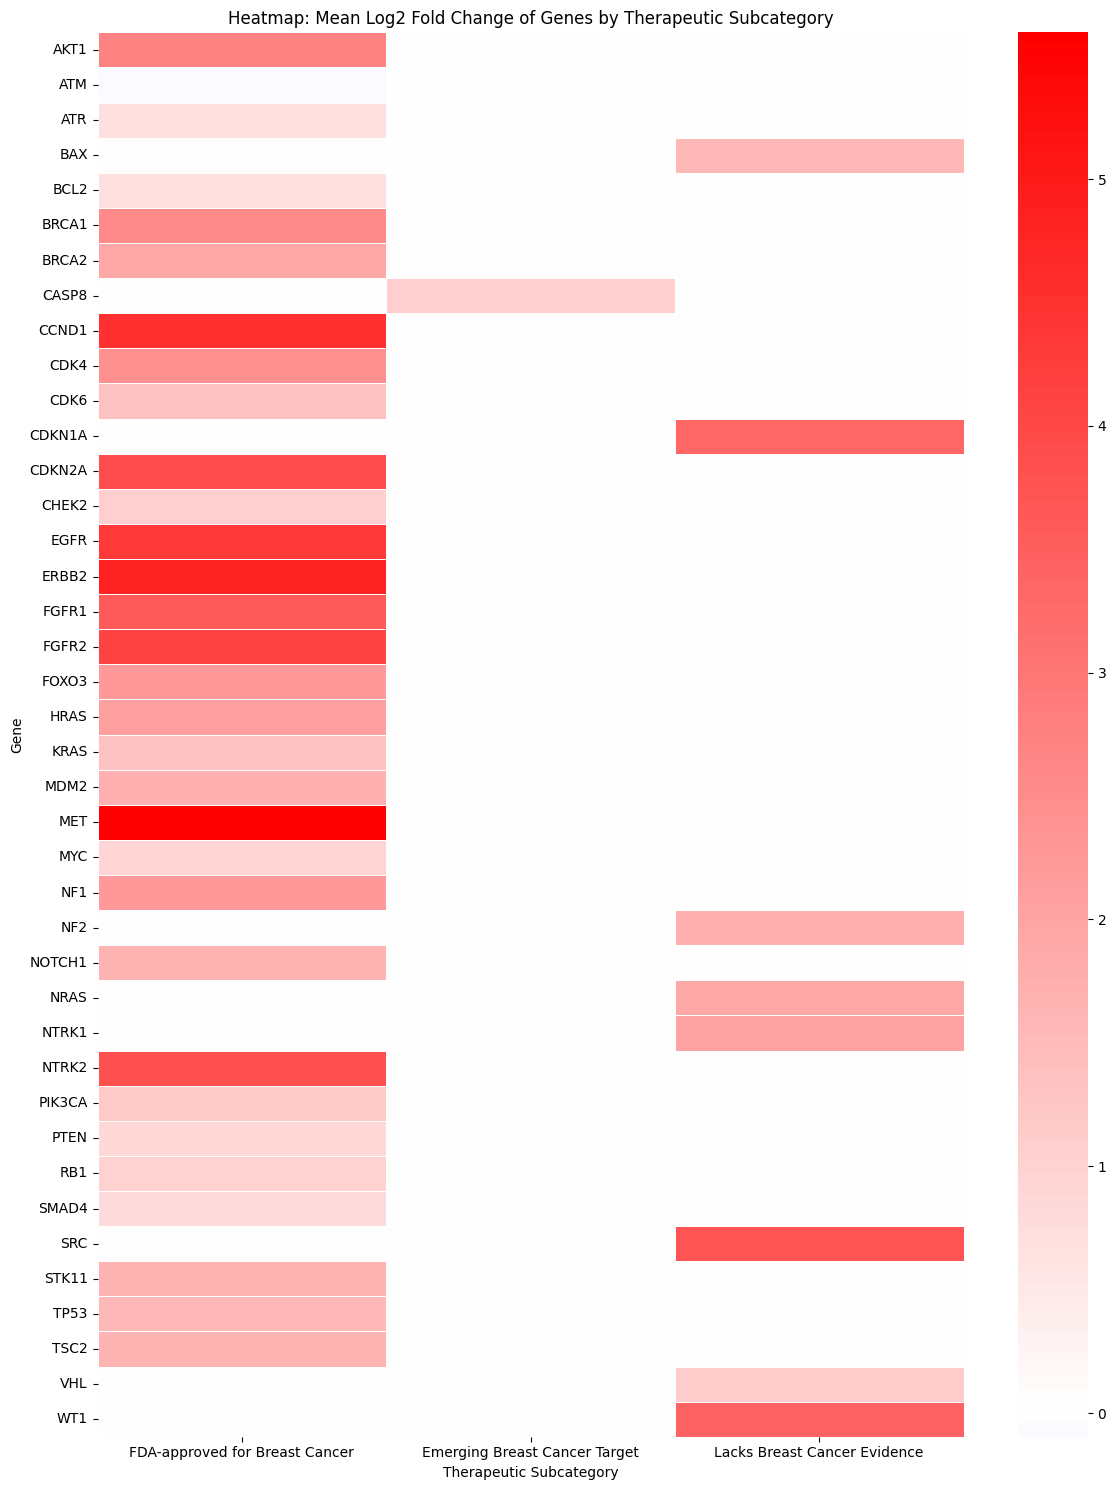

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare pivot table: genes on y-axis, categories/pathways on x-axis, colored by mean log2FC
heatmap_data = df_unique.pivot_table(
    index='gene',
    columns='Therapeutic Subcategory',  # or 'Pathway Category'
    values='log2_fc',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(12, 15))
sns.heatmap(heatmap_data, cmap='bwr', center=0, linewidths=0.5)
plt.title("Heatmap: Mean Log2 Fold Change of Genes by Therapeutic Subcategory")
plt.ylabel('Gene')
plt.xlabel('Therapeutic Subcategory')
plt.tight_layout()
plt.show()


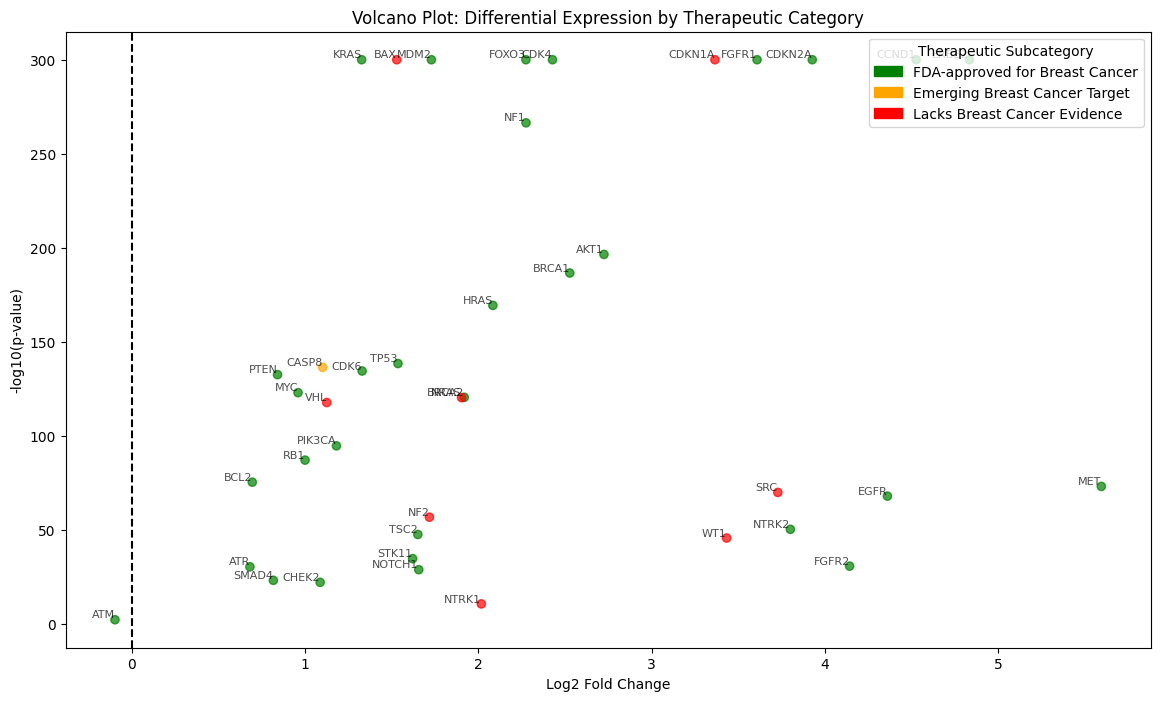

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df_unique['-log10_pval'] = -np.log10(df_unique['p_value'] + 1e-300)  # avoid log(0)
plt.figure(figsize=(14, 8))

# Map colors
color_map = {
    'FDA-approved for Breast Cancer': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}
colors = df_unique['Therapeutic Subcategory'].map(color_map)

scatter = plt.scatter(df_unique['log2_fc'], df_unique['-log10_pval'],
                      c=colors, alpha=0.7)

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Differential Expression by Therapeutic Category')
plt.axvline(0, color='black', linestyle='--')

# Annotate each point with gene name
for i, row in df_unique.iterrows():
    plt.text(row['log2_fc'], row['-log10_pval'], row['gene'],
             fontsize=8, alpha=0.7, ha='right', va='bottom')

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_patches, title="Therapeutic Subcategory", loc='upper right')

plt.show()




/var/folders/kx/1z2nljtd7zqgfpqmrmskdmqc0000gn/T/ipykernel_67893/3411071497.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




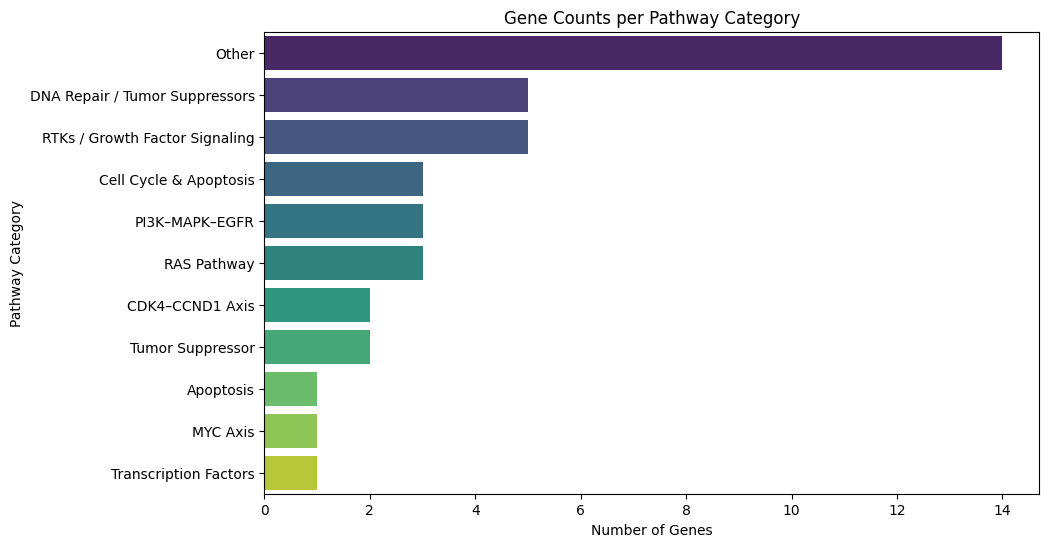

In [48]:
pathway_counts = df_unique.groupby('Pathway Category')['gene'].count().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=pathway_counts.values, y=pathway_counts.index, palette='viridis')
plt.xlabel('Number of Genes')
plt.ylabel('Pathway Category')
plt.title('Gene Counts per Pathway Category')
plt.show()


In [63]:
# Suppose you have a list of genes with FDA-approved drugs specifically for breast cancer
# This list can come from your manual curation or a trusted source.
bc_approved_genes = [
    'ERBB2', 'CDK4', 'CDK6', 'PIK3CA', 'FGFR1', 'FGFR2', 'EGFR', 'BRCA1', 'BRCA2',
    'TP53', 'AKT1', 'MYC', 'KRAS'  # example subset — replace with your verified list
]

def fda_subcategory(row):
    if row['Targeting Category'] != 'FDA-approved Breast Cancer Therapy':
        return None
    if row['gene'] in bc_approved_genes:
        return 'FDA-approved for Breast Cancer'
    else:
        return 'FDA-approved, Other Indication'

df_unique['FDA_Subcategory'] = df_unique.apply(fda_subcategory, axis=1)
print(df_unique['FDA_Subcategory'].value_counts())


FDA_Subcategory
FDA-approved, Other Indication    18
FDA-approved for Breast Cancer    13
Name: count, dtype: int64


In [64]:
import plotly.graph_objects as go

# Fill NAs for non-FDA approved
df_unique['FDA_Subcategory'] = df_unique['FDA_Subcategory'].fillna('N/A')

# Build label list for nodes
targeting_categories = df_unique['Targeting Category'].unique().tolist()
fda_subcats = df_unique['FDA_Subcategory'].unique().tolist()
trial_status = df_unique['Clinical_Trial_Status'].unique().tolist()
genes = df_unique['gene'].unique().tolist()

labels = targeting_categories + fda_subcats + trial_status + genes
label_to_idx = {label: i for i, label in enumerate(labels)}

# Build links lists: source, target, value, colors
source = []
target = []
value = []
link_colors = []

# Colors for categories (customize as needed)
cat_colors = {
    'FDA-approved Breast Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red',
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'N/A': 'lightgrey',
    'In Breast Cancer Trial': 'blue',
    'No Breast Cancer Trial': 'grey'
}

# Helper function to get color for links (source node color)
def get_link_color(src_label):
    return cat_colors.get(src_label, 'lightgrey')

# Targeting Category → FDA Subcategory
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Targeting Category']])
    target.append(label_to_idx[row['FDA_Subcategory']])
    value.append(1)
    link_colors.append(get_link_color(row['Targeting Category']))

# FDA Subcategory → Clinical Trial Status
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['FDA_Subcategory']])
    target.append(label_to_idx[row['Clinical_Trial_Status']])
    value.append(1)
    link_colors.append(get_link_color(row['FDA_Subcategory']))

# Clinical Trial Status → Gene
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Clinical_Trial_Status']])
    target.append(label_to_idx[row['gene']])
    value.append(1)
    link_colors.append(get_link_color(row['Clinical_Trial_Status']))

# Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels,
        pad=15,
        thickness=15,
        line=dict(color='black', width=0.5),
        color=[cat_colors.get(lbl, 'lightgrey') for lbl in labels]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(title_text="Therapeutic Stratification with FDA Subcategories", font_size=12, height=800, width=1200)
fig.show()


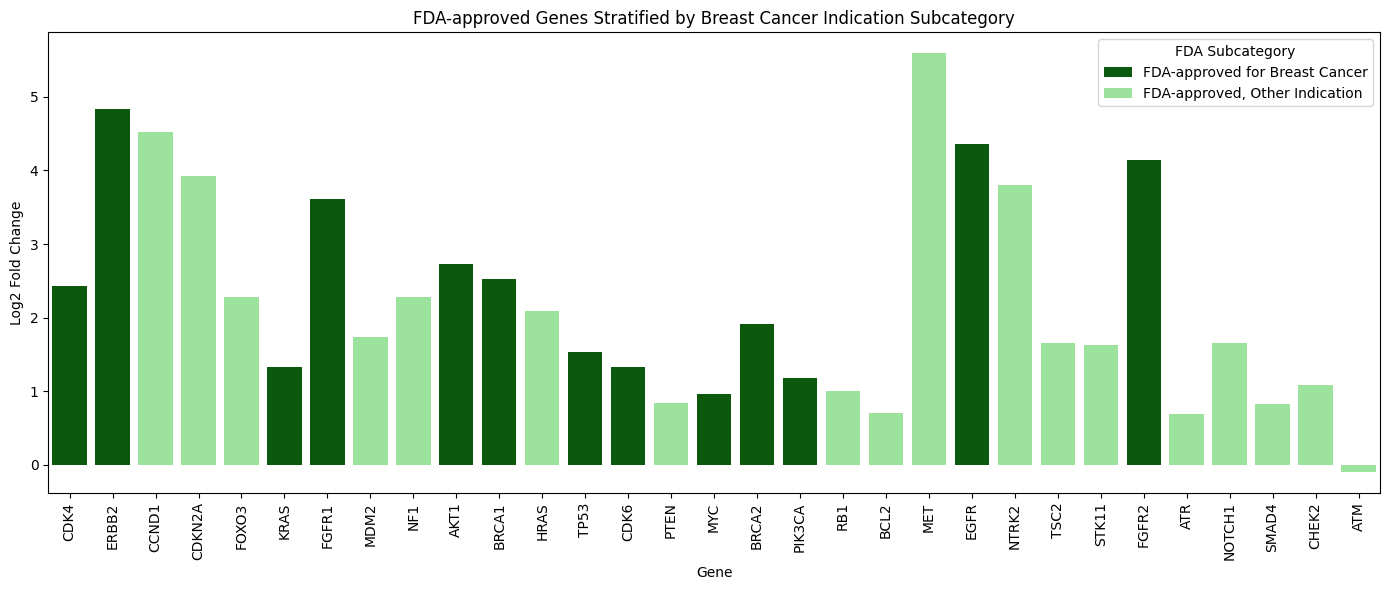

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only FDA-approved genes with subcategory info
df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy'].copy()

plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_fda,
    x='gene',
    y='log2_fc',  # or any metric you want to show on y-axis
    hue='FDA_Subcategory',
    dodge=False,
    palette={'FDA-approved for Breast Cancer': 'darkgreen', 'FDA-approved, Other Indication': 'lightgreen'}
)

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('FDA-approved Genes Stratified by Breast Cancer Indication Subcategory')
plt.legend(title='FDA Subcategory')
plt.tight_layout()
plt.show()


In [66]:
# Assuming df_unique has columns: 'gene', 'FDA_Subcategory', 'Clinical_Trial_Status'

# Filter only FDA-approved genes (both subgroups)
fda_genes = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy']

# Group by FDA_Subcategory and Clinical_Trial_Status, count genes
trial_counts = fda_genes.groupby(['FDA_Subcategory', 'Clinical_Trial_Status'])['gene'].nunique().unstack(fill_value=0)

print(trial_counts)


Clinical_Trial_Status           In Breast Cancer Trial
FDA_Subcategory                                       
FDA-approved for Breast Cancer                      13
FDA-approved, Other Indication                      18


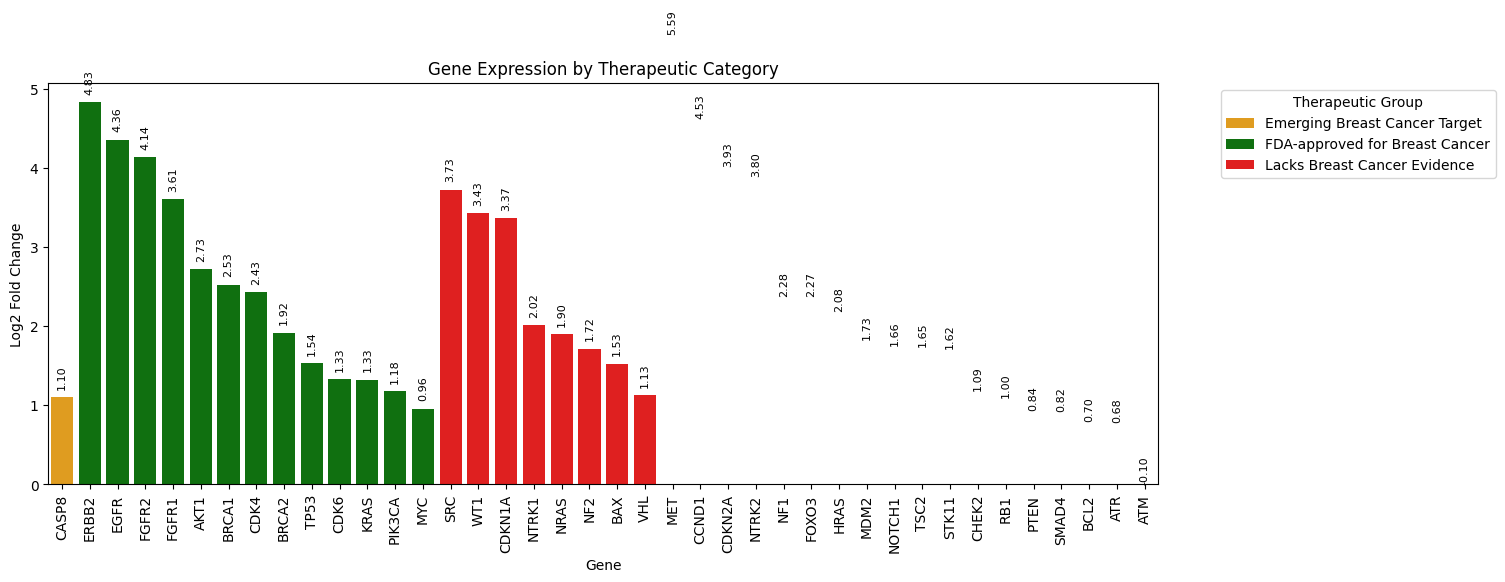

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sort first by group then by fold change descending
df_unique_sorted = df_unique.sort_values(
    by=['Therapeutic Group', 'log2_fc'],
    ascending=[True, False]
).reset_index(drop=True)

plt.figure(figsize=(18, 6))
sns.barplot(
    data=df_unique_sorted,
    x='gene',
    y='log2_fc',
    hue='Therapeutic Group',
    palette={
        'FDA-approved for Breast Cancer': 'green',
        'FDA-approved for Other Indications': 'blue',
        'Emerging Breast Cancer Target': 'orange',
        'Lacks Breast Cancer Evidence': 'red',
        'Other': 'gray'
    },
    dodge=False
)

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('Gene Expression by Therapeutic Category')

# Add numeric labels on top of bars
for index, row in df_unique_sorted.iterrows():
    plt.text(
        x=index,
        y=row['log2_fc'] + 0.1,
        s=f"{row['log2_fc']:.2f}",
        ha='center',
        va='bottom',
        fontsize=8,
        rotation=90
    )

plt.legend(title='Therapeutic Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()




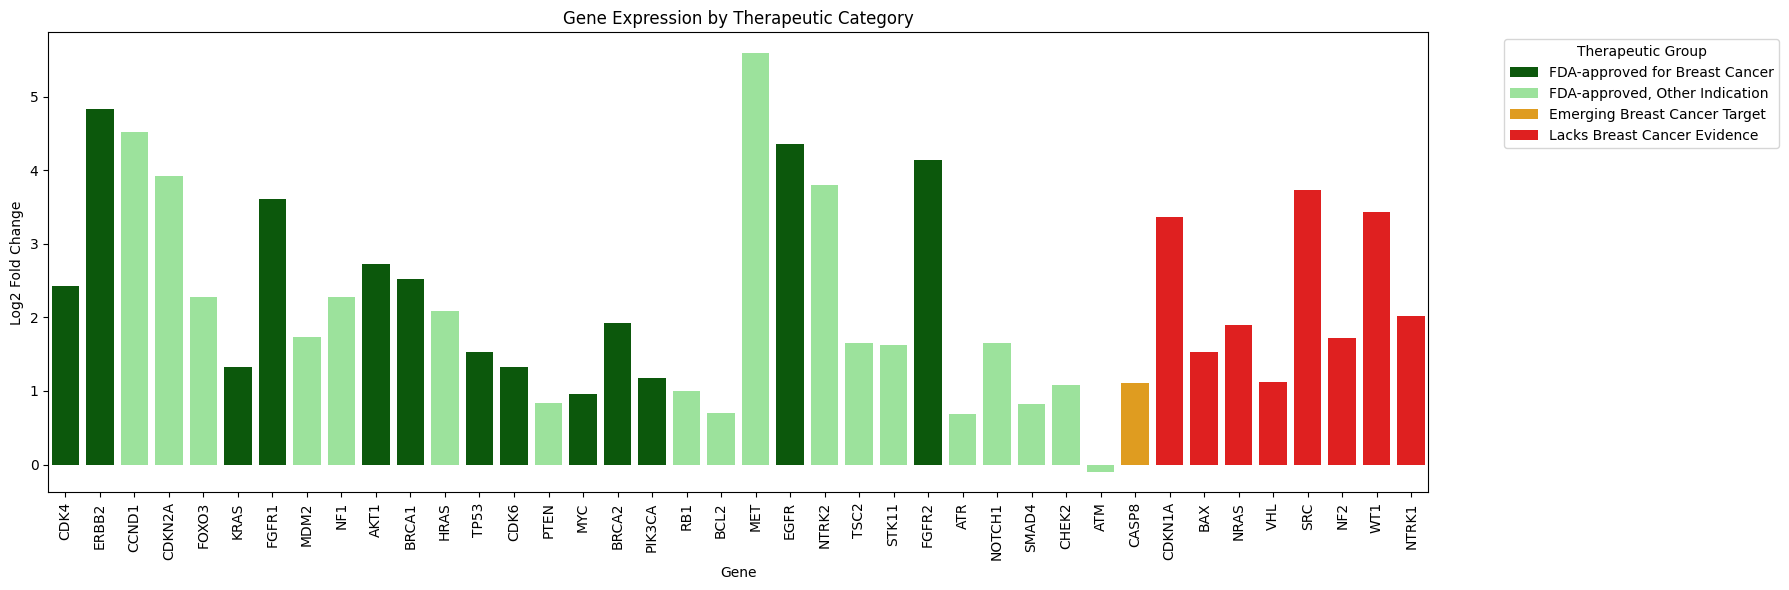

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter subsets for each therapeutic group
df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy'].copy()
df_emerging = df_unique[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target'].copy()
df_lacks = df_unique[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence'].copy()

# For FDA, use 'FDA_Subcategory' as hue
# For emerging and lacks, assign Therapeutic Group label for hue
df_fda['Therapeutic Group'] = df_fda['FDA_Subcategory']

df_emerging['Therapeutic Group'] = 'Emerging Breast Cancer Target'
df_lacks['Therapeutic Group'] = 'Lacks Breast Cancer Evidence'

# Combine all into one DataFrame for plotting
df_plot = pd.concat([df_fda, df_emerging, df_lacks], ignore_index=True)

# Define color palette
palette = {
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}

plt.figure(figsize=(18, 6))
sns.barplot(
    data=df_plot,
    x='gene',
    y='log2_fc',
    hue='Therapeutic Group',
    dodge=False,
    palette=palette
)

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('Gene Expression by Therapeutic Category')
plt.legend(title='Therapeutic Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()






In [94]:
print(df_unique['Therapeutic Subcategory'].unique())


['FDA-approved for Breast Cancer', 'Lacks Breast Cancer Evidence', 'Emerging Breast Cancer Target']
Categories (3, object): ['FDA-approved for Breast Cancer' < 'Emerging Breast Cancer Target' < 'Lacks Breast Cancer Evidence']


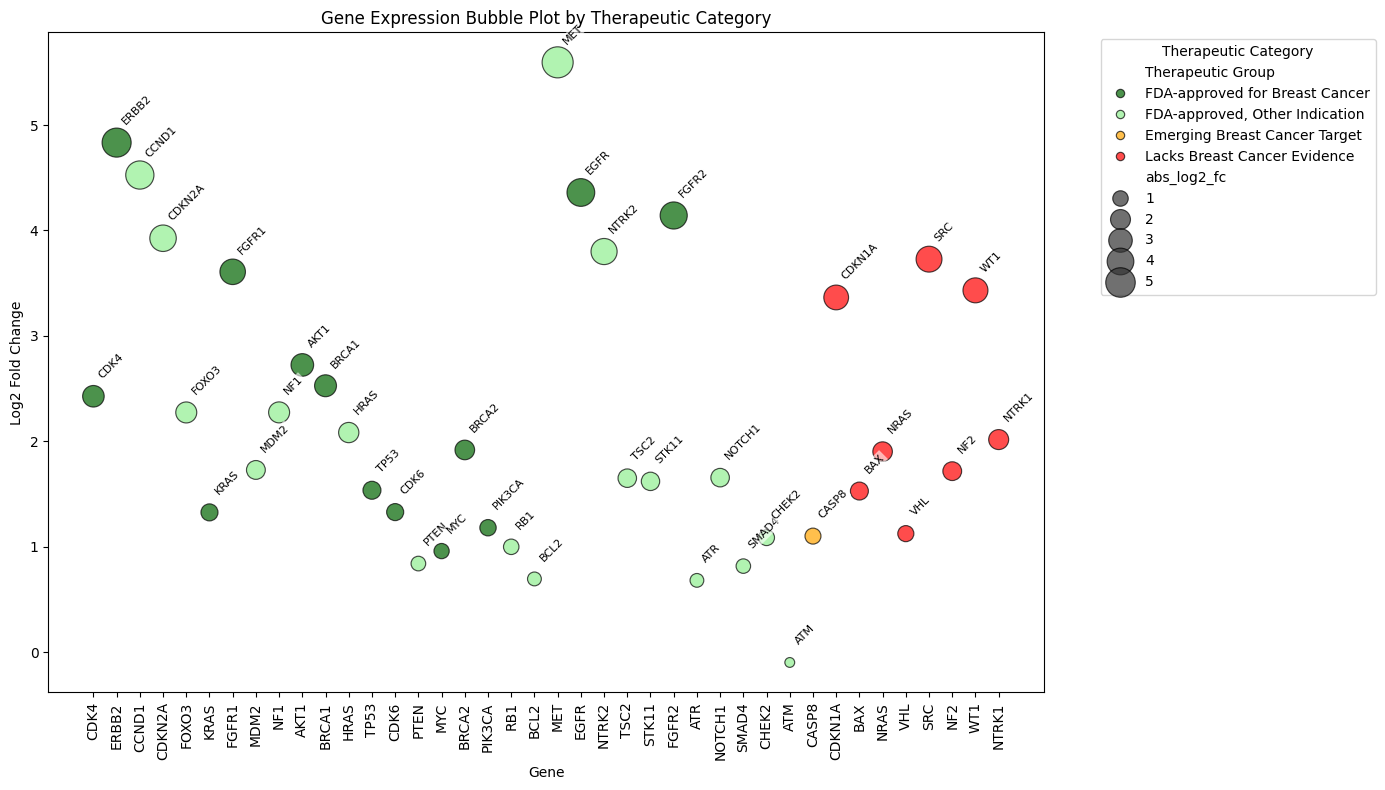

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Prepare absolute log2 fold change for bubble size
df_plot['abs_log2_fc'] = df_plot['log2_fc'].abs()

plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=df_plot,
    x='gene',
    y='log2_fc',
    size='abs_log2_fc',
    hue='Therapeutic Group',
    palette={
        'FDA-approved for Breast Cancer': 'darkgreen',
        'FDA-approved, Other Indication': 'lightgreen',
        'Emerging Breast Cancer Target': 'orange',
        'Lacks Breast Cancer Evidence': 'red',
    },
    sizes=(50, 500),
    alpha=0.7,
    edgecolor='black',
    legend='brief'  # only hue legend
)

# Adjust legend to show only therapeutic group (hue)
handles, labels = scatter.get_legend_handles_labels()
if labels[0] == 'abs_log2_fc':
    handles = handles[1:]
    labels = labels[1:]

plt.legend(handles, labels, title='Therapeutic Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('Gene Expression Bubble Plot by Therapeutic Category')

# Annotate gene names slightly above and to the right of each bubble with background box
for i in range(df_plot.shape[0]):
    plt.text(
        x=i + 0.15,  # shift slightly right
        y=df_plot['log2_fc'].iloc[i] + 0.15,  # shift slightly above
        s=df_plot['gene'].iloc[i],
        fontsize=8,
        rotation=45,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1)
    )

plt.tight_layout()
plt.show()






In [92]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Example DataFrame structure (adjust with your df_unique):

# Assuming df_unique, df_fda, df_emerging, df_lacks are already defined as you shared

# Prepare Therapeutic Group as in your bar plot code:
df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy'].copy()
df_emerging = df_unique[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target'].copy()
df_lacks = df_unique[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence'].copy()

df_fda['Therapeutic Group'] = df_fda['FDA_Subcategory']
df_emerging['Therapeutic Group'] = 'Emerging Breast Cancer Target'
df_lacks['Therapeutic Group'] = 'Lacks Breast Cancer Evidence'

# Combine
df_plot = pd.concat([df_fda, df_emerging, df_lacks], ignore_index=True)
print(df_plot.columns)
# Create label list for nodes (Therapeutic Group, Pathway Category, Clinical Trial, Gene)
labels_therapeutic = df_plot['Therapeutic Group'].unique().tolist()
labels_pathway = df_plot['Pathway Category'].unique().tolist()
labels_trial = df_plot['Clinical_Trial_Status'].unique().tolist()
labels_genes = df_plot['gene'].unique().tolist()

labels = labels_therapeutic + labels_pathway + labels_trial + labels_genes

# Map label to index
label_to_idx = {label: idx for idx, label in enumerate(labels)}

def get_links(source_col, target_col):
    link_df = df_plot.groupby([source_col, target_col]).size().reset_index(name='count')
    sources = link_df[source_col].map(label_to_idx).tolist()
    targets = link_df[target_col].map(label_to_idx).tolist()
    values = link_df['count'].tolist()
    return sources, targets, values

# Links for Sankey
source_1, target_1, value_1 = get_links('Therapeutic Group', 'Pathway Category')
source_2, target_2, value_2 = get_links('Pathway Category', 'Clinical_Trial_Status')
source_3, target_3, value_3 = get_links('Clinical_Trial_Status', 'gene')

sources = source_1 + source_2 + source_3
targets = target_1 + target_2 + target_3
values = value_1 + value_2 + value_3

# Color nodes by Therapeutic Group for clarity (optional)
color_map = {
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}
node_colors = []
for label in labels:
    # If therapeutic group, assign color, else default light grey
    node_colors.append(color_map.get(label, 'lightgrey'))

# Color gene links by log2 fold change (blue for down, red for up)
def logfc_to_color(logfc):
    # Normalize logFC for color intensity
    max_val = max(abs(df_plot['log2_fc'].max()), abs(df_plot['log2_fc'].min()))
    norm_val = logfc / max_val
    if norm_val >= 0:
        # Red shades for upregulated
        return f'rgba(255, 0, 0, {0.3 + 0.7 * norm_val})'
    else:
        # Blue shades for downregulated
        return f'rgba(0, 0, 255, {0.3 + 0.7 * abs(norm_val)})'

# Map genes to colors by log2_fc
gene_color_map = dict(zip(df_plot['gene'], df_plot['log2_fc'].apply(logfc_to_color)))

link_colors = []
for i in range(len(sources)):
    # For links from Clinical Trial Status to Gene, use gene color
    if sources[i] in [label_to_idx[t] for t in labels_trial] and targets[i] in [label_to_idx[g] for g in labels_genes]:
        gene_label = labels[targets[i]]
        link_colors.append(gene_color_map.get(gene_label, 'lightgrey'))
    else:
        link_colors.append('lightgrey')

# Create Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors,
        hovertemplate='%{value} genes<br>From %{source.label} to %{target.label}<extra></extra>'
    )
)])

fig.update_layout(title_text='Therapeutic Stratification Sankey with Log2FC Coloring on Gene Links',
                  font_size=10)

fig.show()




Index(['gene', 'p_value', 'log2_fc', 'mean_diff', 'Dataset', 'Gene',
       'DGIdb Status', 'OpenTargets_Score', 'BreastCancer_Supported',
       'Strong_BreastCancer_Support', 'FDA_Approved_Drug',
       'Targeting Category', 'Therapeutic Subcategory',
       'Clinical_Trial_Status', 'Pathway Category', 'abs_log2_fc',
       'expr_direction', 'bubble_size', '-log10_pval', 'FDA_Subcategory',
       'Therapeutic Group'],
      dtype='object')


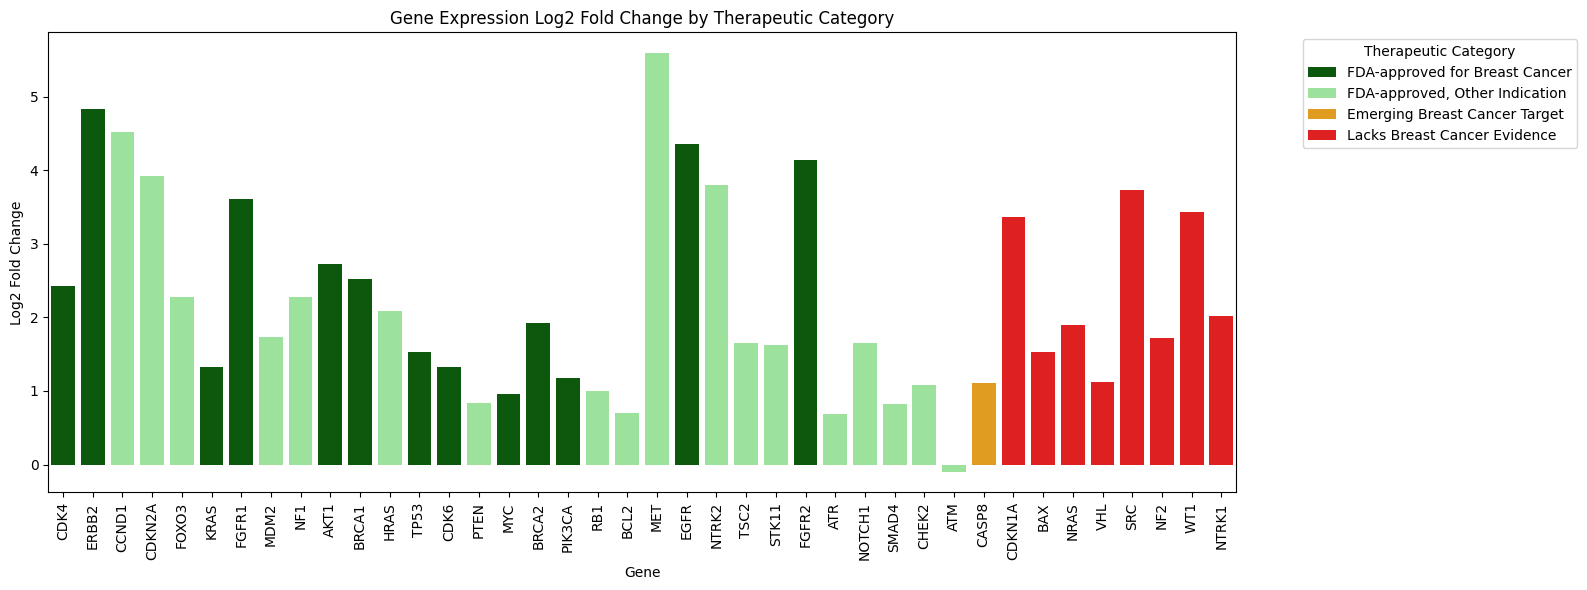

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))

sns.barplot(
    data=df_plot,
    x='gene',
    y='log2_fc',
    hue='Therapeutic Group',
    palette={
        'FDA-approved for Breast Cancer': 'darkgreen',
        'FDA-approved, Other Indication': 'lightgreen',
        'Emerging Breast Cancer Target': 'orange',
        'Lacks Breast Cancer Evidence': 'red',
    }
)

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('Gene Expression Log2 Fold Change by Therapeutic Category')
plt.legend(title='Therapeutic Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
